# Project Report - Anxiety Recognition in Texts

A project about anxiety / stress recognition in texts based on the well-documented Dreaddit Corpus.
>*Note: This is a copy of the Code_clean Notebook, containing the outputs of the project's pipeline execution.*

#### What's Dreaddit?

- A balanced dataset for binary classification (stress vs non-stress)
- Consists of around 3500 raw text samples.
- Each sample is pre-annotated and consists of a 5-sentence sequence of a "starter" Reddit post
- Taken from communities such as r/abuse, r/anxiety, r/PTSD, r/financial, r/relationships.

#### **Goal: Use the dataset to create an informative vocabulary for this specific domain.**
<hr>

#### <ins>An overview of the project's pipeline</ins>

1) Static Preprocessing (handled with the python scripts in the /scripts folder of the project)
    - *Problem:* Some preprocessing techniques are very time intensive, making their implementation unsuitable during training.
    - *Solution:* Preprocess the dataset once and make its output our new starting dataset.
    - **Spellchecking and Lexicon score calculation**

2) Active Processing
    - Tokenization
    - Token processing techniques
    - Tfidf calculation
    - Normalization of lexicon score

3) Validation
    - 5-fold (80/20 splits)
    - Multinomial NB, Logistic Regression, XGBoost
    - **Observe the results and tune active processing to refine vocabulary extraction.**

4) Evaluation
    - Train all the above models + SVM(RBF) on the train dataset.
    - Produce metrics and graphs to evaluate the result.

#### Initial performance on raw corpus with no processing

| **Classifier**      | **Starting macro f1** | **Starting AUC** |
|---------------------|-----------------------|------------------|
| Multinomial NB      | 0.5960                | 0.83             |
| Logistic Regression | 0.7209                | 0.82             |
| SVM (RBF)           | 0.7203                | 0.81             |
| XGBoost             | 0.7118                | 0.78             |

<br>
<hr>

## Imports

In [ ]:
%pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd

from utils.data_loader import load_csv,custom_tokenizer, transform_input

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm

from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets


At this point, the dataset has already been preprocessed with all time intensive methods applied to it.
- Spellchecking
    - Social media posts can be expected to contain a lot of typos
    - Mistyped words not only create new, situational tokens, they also "weaken" the corresponding correct ones.
- Worrywords Lexicon score
    - 44k words
    - Contains a mapping: word -> [-3,3], which is an indicator of how much that word denotes stress / anxiety, or the exact opposite
    - **Extra feature:** avg_lexicon_score(document) = sum(document token scores) / (# of lexicon words in documen)

## Load Dataset & Util Initialization
- Loads the preprocessed training set
- Initializes all the tools needed for the pipeline

In [3]:
lex_scores = []

texts, labels, lex_scores = load_csv('data/dreaddit-train-spellchecked-lex.csv')

# Uncomment for training without lexicon scores
# texts, labels = load_csv('data/dreaddit-train-spellchecked.csv', lexicon=False)

# The tool used to Tokenize and calculate the samples' Tfidf
vectorizer_params = {
    # "stop_words": "english",      # SKLearn's default stopword removal
    "min_df": 3,                    # min no. of documents allowed
    "max_df": 0.2,                  # max % of documents allowed 
    "max_features": 3000,           # retains X best performing tokens
    "ngram_range":(1,3),            # 1 token can be 1-3 words
    "tokenizer": custom_tokenizer,  # custom regex & stemming
    "token_pattern": None           # To suppress warnings
}

vectorizer = TfidfVectorizer(**vectorizer_params)
scaler = MinMaxScaler()

#### <ins>Tfidf Vectorizer Params</ins>
The main source of vocabulary refinement.
- **stop_words**: A set of tokens specifying words that are too frequent to be informative.
    - **SKLearn's default stopword set is too aggressive for this task and is omitted.**
        - Contains words like alone, please which could be strong indicators of anxiety in our case.
        - Contains actual stop words that could offer a lot of information in an n-gram context
- **min_df**: The minimum number of documents that a selected token has to exist in.
    - A way to eliminate noisy tokens from the vocabulary.
- **max_df** (percentage): The maximum % of documents that a selected token can exist in.
    - Similar to min_df but for very frequent, uninformative words.
- **ngram_range**: Probably the biggest factor for refinement when it comes to the vectorizer's params.
<hr>

#### <ins>Custom Tokenizer</ins>
The secondary source of vocabulary refinement. It includes regex for:
- Retrieving tokens with >=2 alphanumericals in a row + words that contain apostrophes
- Retrieving "i, I, i'm, I'm" which is usually omitted
    - Huge importance when using n-grams in the context of this domain.
- Omitting tokens with numbers or underscores in them

It also performs stemming, in an attempt to group similar words and boost their frequency in the dataset.
- Tokens in this dataset are all pretty rare.
    - Negligible amount of tokens cut between 0.2 and 0.8 max_df

## K-Fold Validation

In [4]:
'''The K-Fold validation pipeline.'''

kf = KFold()

# Multinomial NB, Logistic Regression as fast, interpretable models
# SVC and XGBoost for non-linear feature relationships
models = { 
          "Multinomial NB": {"clf": MultinomialNB(), "scores": [], "feature_importance" : []},
          "Logistic Regression" : {"clf": LogisticRegression(C=0.3), "scores": [], "feature_importance" : []},   # Minimal tuning
          # "SVC" : {"clf": svm.SVC(kernel='rbf', probability=True), "scores": [], "feature_importance" : []},
          "XGBoost" : {"clf": XGBClassifier(n_estimators=200,
                              learning_rate=0.05,
                              max_depth=4,
                              gamma=2,
                              subsample=0.8,
                              colsample_bytree=0.8), "scores": [], "feature_importance" : []}                    # Suggested preset - no tuning involved
          }


# Start to iterate the KFold splits
for train_ids, val_ids in kf.split(texts):

    # Retrieves the corresponding samples based on the k-fold split
    X_train_texts = [texts[i] for i in train_ids]
    X_val_texts = [texts[i] for i in val_ids]
    y_train = [labels[i] for i in train_ids]
    y_val = [labels[i] for i in val_ids]
    
    
    X_train = vectorizer.fit_transform(X_train_texts)   # Fits the vectorizer on the training data
    X_val = vectorizer.transform(X_val_texts)           # Uses the fitted vectorizer on the validation data (no retraining)
    
    feature_names = vectorizer.get_feature_names_out()
    
    # Condition added in case I want to run the pipeline for the initial / spellchecked dataset without the lexicon scores
    if any(lex_scores):

      # Retrieve the scores of the train and validation data separately
      X_train_avg_lex_scores = np.array([lex_scores[i] for i in train_ids]).reshape(-1,1)
      X_val_avg_lex_scores = np.array([lex_scores[i] for i in val_ids]).reshape(-1,1)

      
      # Normalization to bring the lexicon scores on the same scale as the Tfidf features
      X_train_lex_scores = scaler.fit_transform(X_train_avg_lex_scores.reshape(-1, 1))  # Fits the scaler on the training lex_scores and normalizes them [0,1]
      X_val_lex_scores = scaler.transform(X_val_avg_lex_scores.reshape(-1,1))           # Normalizes the validation lex_scores according to the training data normalization


      # Adds the extra lexicon feature at the end of the base Tfidf features (horizontal stacking)
      X_train = hstack([X_train, X_train_lex_scores])
      X_val = hstack([X_val, X_val_lex_scores])

      # Training and validation transformed samples are given as a Dataframe to keep track of the actual token each feature represents
      # This helps understand what the "top k performing features" output of each model actually means for the vocabulary 
      X_train = pd.DataFrame(X_train.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))
      X_val = pd.DataFrame(X_val.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))


    # A loop to train and evaluate every model
    for model_name, model in models.items():
        clf = model['clf'].fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        y_score = clf.predict_proba(X_val)
        model['scores'].append(f1_score(y_val, y_pred, average='macro'))




    # FEATURE IMPORTANCE FOR VISUALIZATION LATER

    # XGBoost natively provides feature importance
    xgboost_feature_scores = models['XGBoost']['clf'].get_booster().get_score(importance_type='total_gain')                         #Total gain = sum of info gain across samples
    xgb_df = pd.DataFrame(list(xgboost_feature_scores.items()), columns=["Token", "Score"]).sort_values("Score", ascending=False)
    models['XGBoost']['feature_importance'].append(xgb_df)


    # Feature importance in LR is given by the calculated weights for each feature
    importance = models['Logistic Regression']['clf'].coef_[0]  # Coefficients per feature
    feature_names = np.append(feature_names,'lexicon_score')
    top_features = pd.DataFrame({"Word": feature_names, "Weight": importance}).sort_values("Weight", ascending=False)
    models['Logistic Regression']['feature_importance'].append(top_features)
    
    # Feature importance 
    log_prob = models['Multinomial NB']['clf'].feature_log_prob_
    nb_features = pd.DataFrame({"Token": feature_names, "Class 0":log_prob[0], "Class 1": log_prob[1]}).sort_values(by="Class 1", ascending=False)
    models['Multinomial NB']['feature_importance'].append(nb_features)

## Calculate Score Means and Variances

A way to measure the models' performance after each vectorizer or tokenizer tweak.

**Goal: Move towards improving all 3 different models at once and not overfit to one.**

In [ ]:
'''
Calculates the f1-score mean and variance of each model.
It then creates a dataframe for visualization.
'''

df_data = {'Classifier': [], 'Mean':[], "Variance":[], "Scores":[]}
for model_name, model in models.items():
    mean = np.mean(model['scores'])
    var = np.var(model['scores'])

    df_data['Classifier'].append(model_name)
    df_data['Mean'].append(mean)
    df_data['Variance'].append(var)
    df_data['Scores'].append(model['scores'])
    
scores_df = pd.DataFrame(df_data)
print(scores_df)

# Used to keep (some) track of the models' performance when tuning the vectorizer's parameters.
with open('scores.txt','a') as f:
    f.write(f"\n\n{vectorizer_params}")
    f.write(f"\n{scores_df.to_string()}")

            Classifier      Mean  Variance  \
0       Multinomial NB  0.759195  0.000317   
1  Logistic Regression  0.766354  0.000255   
2              XGBoost  0.724950  0.000512   

                                              Scores  
0  [0.7305707346690953, 0.7609539396773439, 0.763...  
1  [0.7417396512419137, 0.7687634213118779, 0.774...  
2  [0.6934987320609235, 0.7288429823800018, 0.742...  


## Boxplot

A visualization of the above metrics

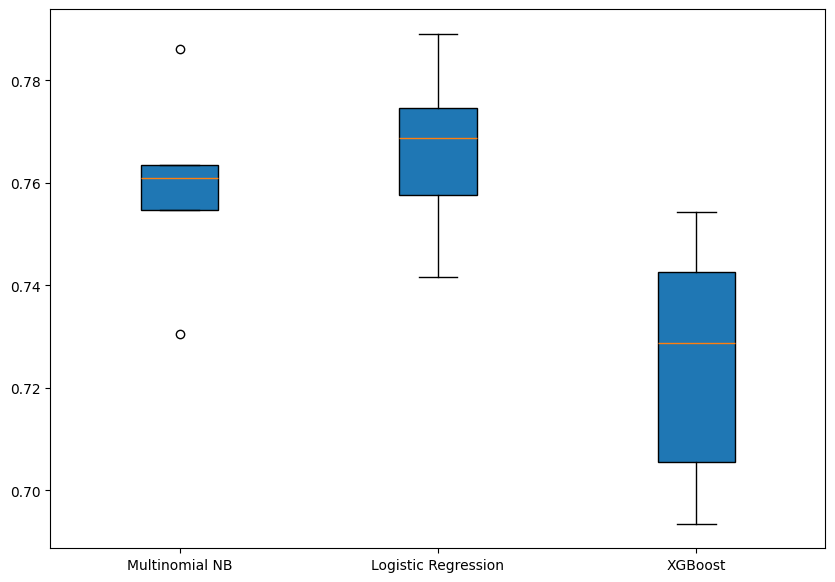

In [6]:
'''Visualizes the above dataframe with a Box plot.'''

scores = []
plot_labels = []

fig = plt.figure(figsize=(10,7))
for model_name, model in models.items():
    scores.append(model['scores'])
    plot_labels.append(model_name)
    
plt.boxplot(scores,patch_artist=True,tick_labels=plot_labels)
plt.show()

## Feature Importance per fold

- A visualization of what the top features for each model are
- Since the change in the scores was marginal for little tweaks in the active processing phase, feature importances were consulted regularly as a guide towards eliminating tokens of lower quality

Each row of dataframes in the display below corresponds to a fold iteration

In [7]:
''' VISUALIZATION OF FEATURE IMPORTANCE FOR EACH FOLD, FOR EACH MODEL'''

# Select the amount of top features to return
k = 5

output1 = widgets.Output()
output2 = widgets.Output()
output3 = widgets.Output()
# Number of folds
for i in range(5):

    xgb_df = models['XGBoost']['feature_importance'][i]
    lr_df = models['Logistic Regression']['feature_importance'][i]
    nb_df = models['Multinomial NB']['feature_importance'][i]

    with output1: display(xgb_df[0:k])
    with output2: display(lr_df[0:k])
    with output3: display(nb_df[0:k])

box1 = widgets.VBox([widgets.Label("XGBoost"), output1], layout=widgets.Layout(align_items='center'))
box2 = widgets.VBox([widgets.Label("Logistic Regression"), output2], layout=widgets.Layout(align_items='center'))
box3 = widgets.VBox([widgets.Label("Multinomial NB"), output3], layout=widgets.Layout(align_items='center'))

three_columns = widgets.HBox([box1,box2,box3])
display(three_columns)

## Training

In [8]:
'''
Follows a very similar worfklow to the K-fold validation one.
Here however we use the whole training set for training and test set for evaluation.
'''

texts, y_train, train_lex_scores = load_csv('data/dreaddit-train-spellchecked-lex.csv')
test_texts, y_test, test_lex_scores = load_csv("./data/dreaddit-test-spellchecked-lex.csv")

# Uncomment for training without lexicon scores
# texts, labels = load_csv('data/dreaddit-train-spellchecked.csv', lexicon=False)
# test_texts, y_test = load_csv("./data/dreaddit-test-spellchecked.csv", lexicon=False)

models = { 
          "Multinomial NB": {"clf": MultinomialNB()},
          "Logistic Regression" : {"clf": LogisticRegression(C=0.3),},
          "SVC" : {"clf": svm.SVC(kernel='rbf', probability=True)},     # SVM enabled here
          "XGBoost" : {"clf": XGBClassifier(n_estimators=200,
                              learning_rate=0.05,
                              max_depth=4,
                              gamma=2,
                              subsample=0.8,
                              colsample_bytree=0.8)}
          }

X_train = vectorizer.fit_transform(texts)
X_test = vectorizer.transform(test_texts)


if any(lex_scores):

    X_train_avg_lex_scores = train_lex_scores
    X_test_avg_lex_scores = test_lex_scores
    
    X_train_lex_scores = scaler.fit_transform(X_train_avg_lex_scores.reshape(-1, 1))
    X_test_lex_scores = scaler.transform(X_test_avg_lex_scores.reshape(-1,1))

    X_train = hstack([X_train, X_train_lex_scores])
    X_test = hstack([X_test, X_test_lex_scores])


    X_train = pd.DataFrame(X_train.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))
    X_test = pd.DataFrame(X_test.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))

for model_name, model in models.items():
    clf = model['clf'].fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    model['y_pred'] = y_pred
    model['y_score'] = y_score
    model['f1_score'] = f1_score(y_test, y_pred, average='macro')

## Test set f1 scores

In [9]:
df_data = {'Classifier': [], "f1_score":[]}
for model_name, model in models.items():
    df_data['Classifier'].append(model_name)
    df_data['f1_score'].append(model['f1_score'])
    
scores_df = pd.DataFrame(df_data)
print(scores_df)


            Classifier  f1_score
0       Multinomial NB  0.724594
1  Logistic Regression  0.754974
2                  SVC  0.757310
3              XGBoost  0.732051


## Confusion Matrices

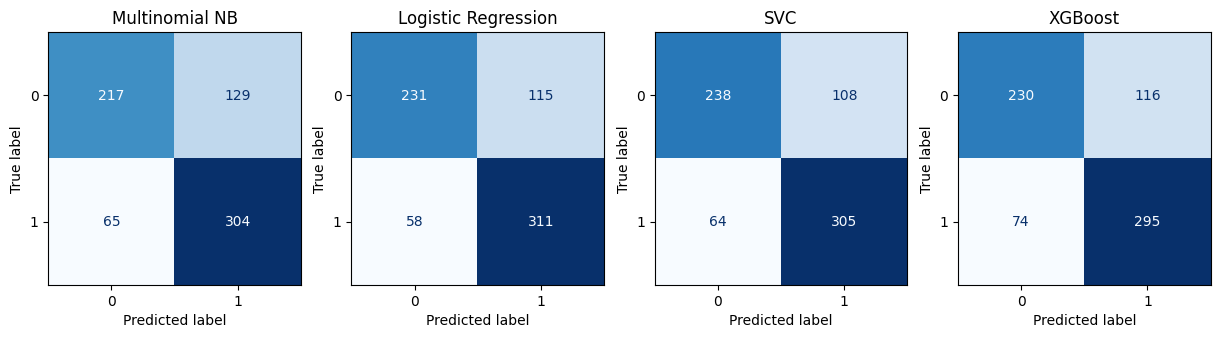

In [10]:
confusion_matrices = {}

for model_name, model in models.items():
    confusion_matrices[model_name] = confusion_matrix(y_test,model['y_pred'])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes= axes.flatten()
for i, (name,cm) in enumerate(confusion_matrices.items()):
    subplot = ConfusionMatrixDisplay(cm)
    axes[i].set_title(name)
    subplot.plot(ax=axes[i], cmap='Blues', colorbar=False)

## ROC Curves

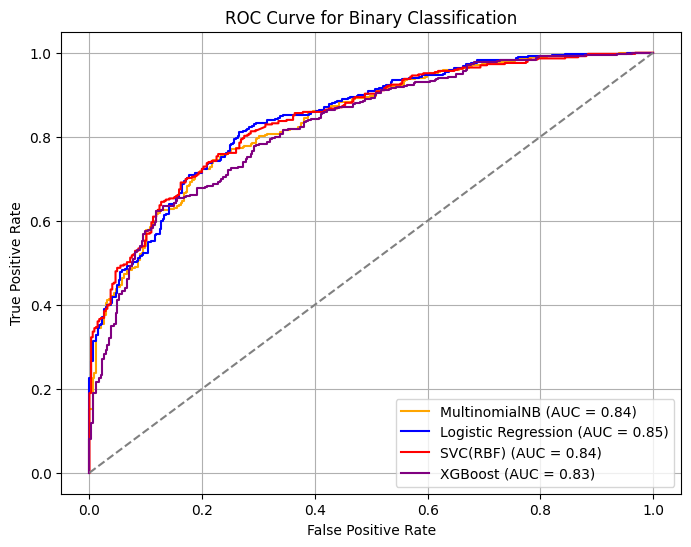

In [11]:
fpr = []
tpr = []
roc_auc = []

for model_name, model in models.items():
    m_fpr, m_tpr, _ = roc_curve(y_test,model['y_score'][:,1]) # Convert labels to one-hot encoding (required for ROC-AUC computation)
    m_roc_auc = auc(m_fpr,m_tpr)
    fpr.append(m_fpr)
    tpr.append(m_tpr)
    roc_auc.append(m_roc_auc)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr[0],tpr[0], label=f'MultinomialNB (AUC = {roc_auc[0]:.2f})', color = 'orange')
plt.plot(fpr[1], tpr[1], label=f'Logistic Regression (AUC = {roc_auc[1]:.2f})', color='blue')
plt.plot(fpr[2],tpr[2], label=f'SVC(RBF) (AUC = {roc_auc[2]:.2f})', color = 'red')
plt.plot(fpr[3],tpr[3], label=f'XGBoost (AUC = {roc_auc[3]:.2f})', color = 'purple')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend()
plt.grid()
plt.show()

## Two inference examples

In [14]:
inference_texts = ["I am very stressed and I have anxiety.","Today I went for a walk in the park. it was Amazing!. I feel very happy and I can't wait to go tomorrow as well."]

for text in inference_texts:
    print(f"Inference text: {text}")

    input = transform_input(text,vectorizer,scaler)

    # print(models['Multinomial NB']['clf'].predict(input))
    print(models['Multinomial NB']['clf'].predict_proba(input))

    # print(models['Logistic Regression']['clf'].predict(input))
    print(models['Logistic Regression']['clf'].predict_proba(input))

    # print(models['SVC']['clf'].predict(input))
    print(models['SVC']['clf'].predict_proba(input))

    # print(models['XGBoost']['clf'].predict(input))
    print(models['XGBoost']['clf'].predict_proba(input))

    print("\n")



Inference text: I am very stressed and I have anxiety.
[[0.18394892 0.81605108]]
[[0.12143512 0.87856488]]
[[0.00939301 0.99060699]]
[[0.17010331 0.8298967 ]]


Inference text: Today I went for a walk in the park. it was Amazing!. I feel very happy and I can't wait to go tomorrow as well.
[[0.33339767 0.66660233]]
[[0.47104617 0.52895383]]
[[0.47568337 0.52431663]]
[[0.4949094 0.5050906]]




It looks like all the models can predict the Positive sample (anxiety detected) with high confidence (>0.8).

It also seems like while all the models do misclassify the second one (a very strong indicator of no-stress), they do so barely.